# Classifier: Neural Network (after internship).

## 1.a. Import: Libraries

In [1]:
#data organizing
import pandas #storage
import numpy as np #data-type conversion
from os import getcwd

#eda visualization
import seaborn

#preprocessing - data splitting
from sklearn.model_selection import train_test_split

#outlier removal to achieve better distribution
from sklearn.ensemble import IsolationForest
# import seaborn #test distribution

#scaling
from sklearn.preprocessing import StandardScaler

#classifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow import feature_column
import tensorflow as tf

#classification result - statistical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

https://www.tensorflow.org/tutorials/estimator/premade

https://www.tensorflow.org/tutorials/structured_data/feature_columns

https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier

https://stackoverflow.com/questions/56612386/defining-the-input-function-for-tensorflow-pre-made-estimator

## 1.b. Import: Dataset

In [2]:
#dtype changed from int64 to int32 to save space and speed up computation, no data was lost
def cvDefPay(prediction):
    mapper = {0: False, 1: True}
    return mapper.get(prediction)

url = getcwd() + '\\default of credit card clients.xls'
ccd = pandas.read_excel(io = url, \
                        sheet_name='Data', header = 1, index_col = 0, \
                        dtype = {'LIMIT_BAL': np.int32, 'AGE': np.int32, 'BILL_AMT1': np.int32, 'BILL_AMT2': np.int32, 'BILL_AMT3': np.int32, 'BILL_AMT4': np.int32, 'BILL_AMT5': np.int32, 'BILL_AMT6': np.int32, 'PAY_AMT1': np.int32, 'PAY_AMT2': np.int32, 'PAY_AMT3': np.int32, 'PAY_AMT4': np.int32, 'PAY_AMT5': np.int32, 'PAY_AMT6': np.int32})
                        #,converters = {'default payment next month': cvDefPay})

In [3]:
ccd.rename(columns = {'PAY_0': 'PAY_1'}, inplace = True)
ccd.rename(columns = {'default payment next month': 'default_payment_next_month'}, inplace = True)

## 3.b. Feature Engineering

### 3.b.1. PAY {PAY_1 to PAY_6}

1. Using mode to aggregate. An entry may have mutiple mode values (same frequency), to resolve, using severest class.

2. Why severest value? To ensure fiscally fit population of credit users.

In [4]:
ccdr = pandas.read_excel(io = url, 
                        sheet_name='Data', header = 1, index_col = 0)
ccdr.rename(columns = {'PAY_0': 'PAY_1'}, inplace = True)

In [5]:
ccdrHistory = ccdr[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]

In [6]:
ccdrHistoryMode = ccdrHistory.mode(axis = 'columns')
ccdPayHistoryMode = ccdrHistoryMode.apply(func = max, axis = 'columns')

In [7]:
ccd['PAY_MODE_SEVEREST'] = list(ccdPayHistoryMode)

### 3.b.2. BILL_AMT {BILL_AMT1 to BILL_AMT6}

Using mean for total credit used

In [8]:
ccdSpent = ccd[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]

In [9]:
ccd['BILL_AMT_MEAN'] = np.int32(ccdSpent.mean(axis = 'columns').round())

### 3.b.3. PAY_AMT {PAY_AMT1 to PAY_AMT6}

Using mean for total credit settled

In [10]:
ccdSettled = ccd[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]

In [11]:
ccd['PAY_AMT_MEAN'] = np.int32(ccdSettled.mean(axis = 'columns').round())

## 3.c. Normalization

Scaling: Only to reduce the effect of very large continuous variables (in distance based esimators).

Normalization: Also reduce the effect of skewness in variables.

In [12]:
varsToScale = ['LIMIT_BAL', 'AGE', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 
               'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'BILL_AMT_MEAN', 'PAY_AMT_MEAN']
scaler = StandardScaler(copy = False)

In [13]:
for var in varsToScale:
    ccd[var] = scaler.fit_transform(ccd[var].values.reshape(-1, 1))


## 3.a. Removing Outliers

Since data is highly skewed with the higher end being very sparse, having mostly outliers,

It may be better to remove those outliers so rest of the dataset has better distribution for better prediction
And outlier datapoints could be have a separate classifier model

Sould be done before data split to ensure distribution of train, dev and test sets are not different from each other.

In [14]:
isolationForest = IsolationForest(n_estimators = 100, max_samples = 0.2, contamination = 'auto',
                       n_jobs = -1, random_state = 39)

In [15]:
isolationForest.fit(ccd)
IsOutlierLabels = isolationForest.predict(ccd)

In [16]:
def cvIsOutlier(prediction):
    mapper = {-1: True, 1: False}
    return mapper.get(prediction)

ccdOutliers = ccd.copy(deep = True)

In [17]:
ccdOutliers['IsOutlier'] = list(map(cvIsOutlier, IsOutlierLabels))

In [18]:
#inliers conditions have been selected from EDA observations

ccdInliers = ccd[(ccdOutliers['IsOutlier'] == False) & (ccdOutliers['LIMIT_BAL'] <= 525000) & (ccdOutliers['AGE'] <= 60)]
ccdOutliers = ccd[~ccd.index.isin(ccdInliers.index)]

In [19]:
ccdInliers

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month,PAY_MODE_SEVEREST,BILL_AMT_MEAN,PAY_AMT_MEAN
ID,,,,,,,,,,,,,,,,,,,,,
1,-1.136720,2,2,1,-1.246020,2,2,-1,-1,-2,...,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382,1,2.0,-0.690692,-0.509010
2,-0.365981,2,2,2,-1.029047,-1,2,0,0,0,...,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878,1,0.0,-0.666000,-0.438186
3,-0.597202,2,2,2,-0.161156,0,0,0,0,0,...,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122,0,0.0,-0.443172,-0.339249
4,-0.905498,2,2,1,0.164303,0,0,0,0,0,...,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130,0,0.0,-0.101501,-0.382454
5,-0.905498,1,2,1,2.334029,-1,0,-1,0,0,...,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187,0,0.0,-0.422923,0.450470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,0.404759,1,3,1,0.381275,0,0,0,0,0,...,0.171250,0.611048,-0.012648,-0.113564,0.013131,-0.237130,0,0.0,1.200055,0.179208
29997,-0.134759,1,3,2,0.815221,-1,-1,-1,-1,0,...,-0.231032,-0.103955,0.214255,-0.299828,-0.314136,-0.293382,0,-1.0,-0.655188,-0.282136
29998,-1.059646,1,2,2,0.164303,4,3,2,-1,0,...,-0.341942,-0.256990,0.952725,-0.039964,-0.183229,-0.119001,1,0.0,-0.525263,-0.005744


In [20]:
ccdOutliers

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month,PAY_MODE_SEVEREST,BILL_AMT_MEAN,PAY_AMT_MEAN
ID,,,,,,,,,,,,,,,,,,,,,
7,2.562830,1,1,2,-0.703588,0,0,0,0,0,...,2.978712,1.479085,1.861472,0.983852,0.585848,0.481207,0,0.0,6.467344,2.451303
18,1.175499,1,1,1,1.466139,0,0,0,-1,-1,...,0.283428,0.177029,4.016337,0.968596,12.488479,2.519214,0,0.0,1.834108,5.429274
41,1.483795,1,1,2,-0.269643,0,0,0,0,0,...,0.261814,0.046824,0.043979,11.746145,1.518558,-0.068374,0,0.0,3.638148,3.488414
103,2.408682,1,1,1,2.984947,0,0,0,2,2,...,0.628776,2.160190,0.668742,-0.308063,0.864025,1.067915,0,0.0,6.563298,1.632781
159,0.327685,1,3,1,1.032193,2,3,4,4,5,...,0.290673,0.197775,0.332392,0.399078,0.450228,0.296026,1,4.0,1.411090,0.552662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29838,2.562830,1,1,2,-0.161156,0,0,0,0,0,...,0.710887,0.561222,0.650169,0.665006,0.681802,0.608730,0,0.0,6.726404,1.114817
29868,1.329647,1,1,2,-0.703588,-1,0,0,0,0,...,17.773069,0.316523,0.385043,0.522085,0.341118,0.381922,0,0.0,3.310135,5.402640
29884,1.946238,1,1,1,-0.161156,0,0,0,0,0,...,0.865569,0.784655,0.327962,0.330267,-0.314136,0.325389,0,0.0,6.831146,0.729131


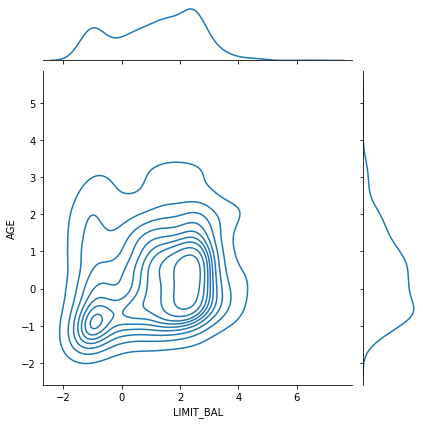

In [21]:
seaborn.jointplot(x = ccdOutliers['LIMIT_BAL'], y = ccdOutliers['AGE'], kind = 'kde')

C:\Users\AnkitApurv\.conda\envs\CreditDefaulterClassification\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\AnkitApurv\.conda\envs\CreditDefaulterClassification\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='LIMIT_BAL', ylabel='Density'>

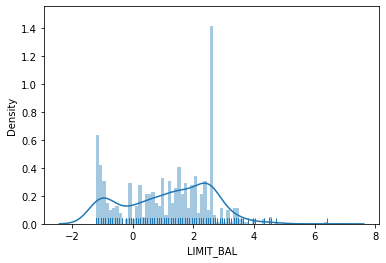

In [22]:
seaborn.distplot(a = ccdOutliers['LIMIT_BAL'], bins = ccdOutliers['LIMIT_BAL'].value_counts().size, kde = True, hist = True, rug = True)

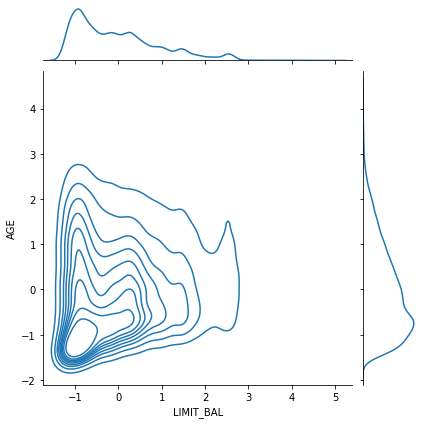

In [23]:
seaborn.jointplot(x = ccdInliers['LIMIT_BAL'], y = ccdInliers['AGE'], kind = 'kde')

C:\Users\AnkitApurv\.conda\envs\CreditDefaulterClassification\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\AnkitApurv\.conda\envs\CreditDefaulterClassification\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='LIMIT_BAL', ylabel='Density'>

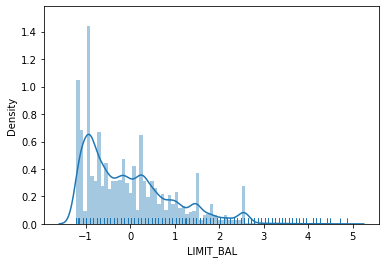

In [24]:
seaborn.distplot(a = ccdInliers['LIMIT_BAL'], bins = ccdInliers['LIMIT_BAL'].value_counts().size, kde = True, hist = True, rug = True)

further inlier outlier correctness validation via pay_amt_mean, bill_amt_mean

## 3.d. Data Splitting

Data is split before oversampling to avoid synthetic datapoints in test dataset.

Test dataset is separated even though GridSearchCV uses Stratified K-Fold cross-validation so that model's accuracy can be tested independently.

In [25]:
ccdY = pandas.DataFrame(ccdInliers['default_payment_next_month'])
ccdX = ccdInliers.drop(['default_payment_next_month'], axis = 'columns')

https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensors

train_set = tf.data.Dataset.from_tensors((trainX.values, trainY.values))

validation_set/dev_set = tf.data.Dataset.from_tensors((validationX.values, validationY.values))

test_set = tf.data.Dataset.from_tensors((testX.values, testY.values))

In [26]:
trainX, testX, trainY, testY = train_test_split(ccdX, ccdY, test_size = 0.25, stratify = ccdY, random_state = 44)

devX, testX, devY, testY = train_test_split(testX, testY, test_size = 0.25, stratify = testY, random_state = 44)



## Model training

In [27]:
def input_fnx(features, labels, validation = True, batch_size = 256):
    train_data = tf.data.Dataset.from_tensor_slices((trainX.to_dict(orient = 'list'), trainY.values))
    dev_data = tf.data.Dataset.from_tensor_slices((devX.to_dict(orient = 'list'), devY.values))
    test_data = tf.data.Dataset.from_tensor_slices((testX.to_dict(orient = 'list'), testY.values))
    #An input function for training or evaluating
    # Convert the inputs to a Dataset.
    dataset = train_data

    # Shuffle and repeat if you are in training mode.
    if validation:
        dataset = dev_data
    
    return dataset.batch(batch_size)

In [28]:
test_data = tf.data.Dataset.from_tensor_slices((testX.to_dict(orient = 'list'), testY.values))
#test_data

#for feat, targ in test_data.take(1):
#  print ('Features: {}, Target: {}'.format(feat, targ))


## 4. Classifier

In [29]:
limit_bal = feature_column.embedding_column('LIMIT_BAL', dimension = ccd['LIMIT_BAL'].nunique())

sex1 = feature_column.categorical_column_with_vocabulary_list('SEX', [1, 2])
sex = feature_column.indicator_column(sex1)

education1 = feature_column.categorical_column_with_vocabulary_list('EDUCATION', [0, 1, 2, 3, 4, 5, 6])
education = feature_column.indicator_column(education1)

marriage1 = feature_column.categorical_column_with_vocabulary_list('MARRIAGE', [0, 1, 2, 3])
marriage = feature_column.indicator_column(marriage1)

age = feature_column.numeric_column('AGE')

pay_11 = feature_column.categorical_column_with_vocabulary_list('PAY_1', [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
pay_1 = feature_column.indicator_column(pay_11)

pay_21 = feature_column.categorical_column_with_vocabulary_list('PAY_2', [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
pay_2 = feature_column.indicator_column(pay_21)

pay_31 = feature_column.categorical_column_with_vocabulary_list('PAY_3', [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
pay_3 = feature_column.indicator_column(pay_31)

pay_41 = feature_column.categorical_column_with_vocabulary_list('PAY_4', [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
pay_4 = feature_column.indicator_column(pay_41)

pay_51 = feature_column.categorical_column_with_vocabulary_list('PAY_5', [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
pay_5 = feature_column.indicator_column(pay_51)

pay_61 = feature_column.categorical_column_with_vocabulary_list('PAY_6', [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
pay_6 = feature_column.indicator_column(pay_61)

pay_m1 = feature_column.categorical_column_with_vocabulary_list('PAY_MODE_SEVEREST', [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
pay_m = feature_column.indicator_column(pay_m1)

bill_amt1 = feature_column.numeric_column('BILL_AMT1')
bill_amt2 = feature_column.numeric_column('BILL_AMT2')
bill_amt3 = feature_column.numeric_column('BILL_AMT3')
bill_amt4 = feature_column.numeric_column('BILL_AMT4')
bill_amt5 = feature_column.numeric_column('BILL_AMT5')
bill_amt6 = feature_column.numeric_column('BILL_AMT6')
bill_amtx = feature_column.numeric_column('BILL_AMT_MEAN')

pay_amt1 = feature_column.numeric_column('PAY_AMT1')
pay_amt2 = feature_column.numeric_column('PAY_AMT2')
pay_amt3 = feature_column.numeric_column('PAY_AMT3')
pay_amt4 = feature_column.numeric_column('PAY_AMT4')
pay_amt5 = feature_column.numeric_column('PAY_AMT5')
pay_amt6 = feature_column.numeric_column('PAY_AMT6')
pay_amtx = feature_column.numeric_column('PAY_AMT_MEAN')

ccd_feature_columns = [limit_bal, sex, education, marriage, age,
                   pay_1, pay_2, pay_3, pay_4, pay_5, pay_6, pay_m,
                   bill_amt1, bill_amt2, bill_amt3, bill_amt4, bill_amt5, bill_amt6, bill_amtx,
                   pay_amt1, pay_amt2, pay_amt3, pay_amt4, pay_amt5, pay_amt6, pay_amtx]

#initial_feature_count = 23
#dimention_reduced_count = 5

In [30]:
#classifier = tf.estimator.DNNClassifier(feature_columns = ccd_feature_columns,
#                                        hidden_units = [23, 5], n_classes = 2,
#                                        model_dir = getcwd())

def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(26, activation='relu', name = 'input'),
    tf.keras.layers.Dense(5, activation='relu', name = 'hidden'),
    tf.keras.layers.Dense(1, activation='sigmoid', name = 'output')
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

classifier = get_compiled_model()

In [31]:
#classifier.train(input_fn = lambda: input_fnx(features = ccdX, labels = ccdY, validation = False), steps=25)

In [32]:
tslist = []
for col in trainX.columns:
    tslist.append(tf.constant(trainX[col]))
    

In [33]:
classifier.fit(x = np.array(trainX), y = np.array(trainY), workers = 6, use_multiprocessing = True)

690/690 [==============================] - 1s 1ms/step - loss: 0.7076 - accuracy: 0.7903


In [34]:
predictY = classifier.predict(x = np.array(testX), workers = 6, use_multiprocessing = True)

In [35]:
def binarysoftmax(val):
    k = 0
    if val < 0.5:
        k = 0
    elif val >= 0.5:
        k = 1
    return k

bsm = np.vectorize(binarysoftmax)

predictYY = bsm(predictY)

In [36]:
print(classification_report(testY, predictYY))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1439
           1       0.65      0.20      0.31       401

    accuracy                           0.80      1840
   macro avg       0.73      0.59      0.60      1840
weighted avg       0.78      0.80      0.76      1840



In [37]:
pandas.DataFrame(
    confusion_matrix(testY, predictYY),
    columns=['Predicted | Not Defaulter', 'Defaulter'],
    index=['Correct | Not Defaulter', 'Defaulter'])

,Predicted | Not Defaulter,Defaulter
Correct | Not Defaulter,1394,45
Defaulter,319,82


In [38]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0
